### 01 packages

In [84]:
##########################################################################################
##########################################################################################

import matplotlib

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

##########################################################################################
##########################################################################################

import numpy as np

import pandas as pd

import random

##########################################################################################
##########################################################################################

from scipy.stats import truncnorm

from shapely.geometry import Point,Polygon

import networkx as nx

import math

##########################################################################################
##########################################################################################

import warnings

warnings.filterwarnings("ignore")

### 02 parameters

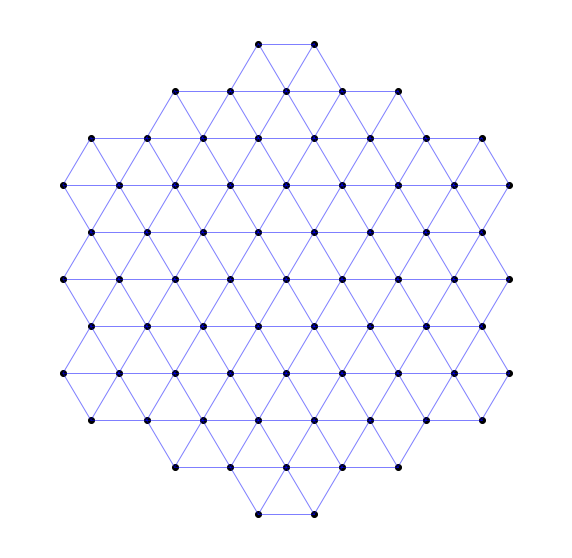

In [85]:
instance='01'

##########################################################################################
##########################################################################################

Hexagons=np.load('./01network/01/Hexagons.npy')

Hexagon_Layer=np.load('./01network/01/Hexagon_Layer.npy',allow_pickle=True).item()


##########################################################################################
##########################################################################################

Hexagon_nodes=np.load("./01network/01/Hexagon_nodes.npy",allow_pickle=True).item()

Hexagon_edges=np.load("./01network/01/Hexagon_edges.npy",allow_pickle=True).item()

##########################################################################################
##########################################################################################

Hexagon_Vertices=np.load("./01network/"+instance+"/Hexagon_Vertices.npy",allow_pickle=True).item()

Hexagon_Center=np.load("./01network/"+instance+"/Hexagon_Center.npy",allow_pickle=True).item()

Hexagons_Neighbors=np.load("./01network/"+instance+"/Hexagons_Neighbors.npy",allow_pickle=True).item()


##########################################################################################
##########################################################################################

Nodes=np.load("./01network/01/Nodes.npy")

Edges=np.load("./01network/01/Edges.npy")

##########################################################################################
##########################################################################################

Road_Graph = nx.Graph()

for node in Nodes:
    
    node=tuple(node)
        
    Road_Graph.add_node(node)

for edge in Edges:
    
    node1=tuple(edge[0])
    
    node2=tuple(edge[1])
    
    Road_Graph.add_edge(node1, node2, weight=Point(node1).distance(Point(node2)))


##########################################################################################
##########################################################################################

figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])
    
for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=1,linestyle='-',alpha=.5)

for node in Road_Graph.nodes:
    
    axs.scatter(node[0], node[1], color='black')

    
# Hide the x and y axes
plt.axis('off')

plt.show()


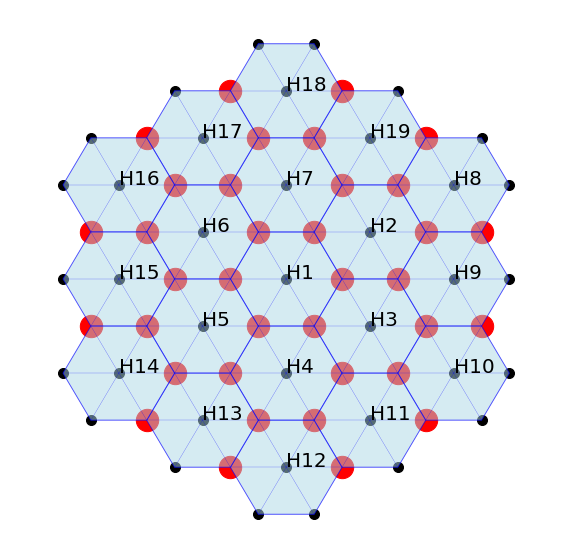

In [86]:
##########################################################################################
##########################################################################################

Lockers=np.load("./01network/"+'01'+"/Lockers.npy")

Lockers=tuple([(x[0],x[1]) for x in Lockers])

Locker_Hexagon=np.load("./01network/"+'01'+"/Locker_Hexagon.npy",allow_pickle=True).item()

Hexagon_Locker=np.load("./01network/"+'01'+"/Hexagon_Locker.npy",allow_pickle=True).item()

##########################################################################################
##########################################################################################

figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])

for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=.2,linestyle='-')

for vertice in Hexagon_Vertices.values():
    
    hexagon = matplotlib.patches.Polygon(vertice, closed=True, edgecolor='blue', facecolor='lightblue',alpha=0.5)
    
    axs.add_patch(hexagon)

    
for hexagon_id, center in Hexagon_Center.items():
    
    axs.text(center[0], center[1], hexagon_id, fontsize=20, color='black')

for node in Road_Graph.nodes:
    
    if node not in Lockers:
    
        axs.scatter(node[0], node[1], color='black',s=100,alpha=1)
        
    else:
        
        axs.scatter(node[0], node[1], color='red',s=500,alpha=1)

        
    
# Hide the x and y axes

plt.axis('off')

plt.show()



### read the corresponding demand

In [87]:

lambda_value = 20

pattern='centralized'#'centralized','uniform'


##########################################################################################
##########################################################################################


Region_G = nx.Graph()

Region_G.add_nodes_from(Hexagons)

for hexagon_id in Hexagons_Neighbors:
    
    for neighor_id in Hexagons_Neighbors[hexagon_id]:
        
        Region_G.add_edge(hexagon_id, neighor_id)

##########################################################################################
##########################################################################################

parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')

parcel_df=parcel_df.drop(columns=['Unnamed: 0'])

parcel_df['shortest_region_path']=parcel_df.apply(lambda x:nx.shortest_path(Region_G, source=x.h1, target=x.h2),axis=1)

##########################################################################################
##########################################################################################

exploded_parcel_df = parcel_df.explode('shortest_region_path')

##########################################################################################
##########################################################################################

exploded_statistics=exploded_parcel_df.groupby('shortest_region_path').count()

exploded_statistics=exploded_statistics.reset_index()

exploded_statistics=exploded_statistics[['shortest_region_path','parcel_id']]

exploded_statistics=exploded_statistics.rename(columns={'shortest_region_path':'hexagon','parcel_id':'parcel_num'})

##########################################################################################
##########################################################################################

parcel_nums={h:0 for h in Hexagons}

for idx,row in exploded_statistics.iterrows():
    
    parcel_nums[row.hexagon]=row.parcel_num
    
allocations={h:1 for h in Hexagons}

while sum(allocations.values())<28:
    
    parcel_supply_ratio={h:parcel_nums[h]/allocations[h] for h in Hexagons}
    
    select_h=max(parcel_supply_ratio, key=lambda k: parcel_supply_ratio[k])
    
    allocations[select_h]+=1
    
##########################################################################################
##########################################################################################


In [88]:
##########################################################################################
##########################################################################################
 
courier_ids=list()

courier_nodes=list()

courier_hexagons=list()

idx=0

for hexagon in Hexagons:
    
    nums=allocations[hexagon]
    
    for i in range(nums):
        
        idx+=1
        
        courier_id='c'+str(idx)
        
        courier_ids.append(courier_id)
        
        courier_nodes.append(random.choice(Hexagon_nodes[hexagon]))
        
        courier_hexagons.append(hexagon)

courier_df=pd.DataFrame([])

courier_df['courier_id']=courier_ids

courier_df['courier_coord']=courier_nodes

courier_df['t']=0

courier_df['x']=courier_df.apply(lambda x:x.courier_coord[0],axis=1)

courier_df['y']=courier_df.apply(lambda x:x.courier_coord[1],axis=1)

courier_df=courier_df[['courier_id', 't', 'x', 'y']]

courier_df['hexagon']=courier_hexagons

##########################################################################################
##########################################################################################
    
# courier_df.to_csv('./02data/01/courier_instance'+str(lambda_value)+'_'+pattern+'.csv')

### visualization

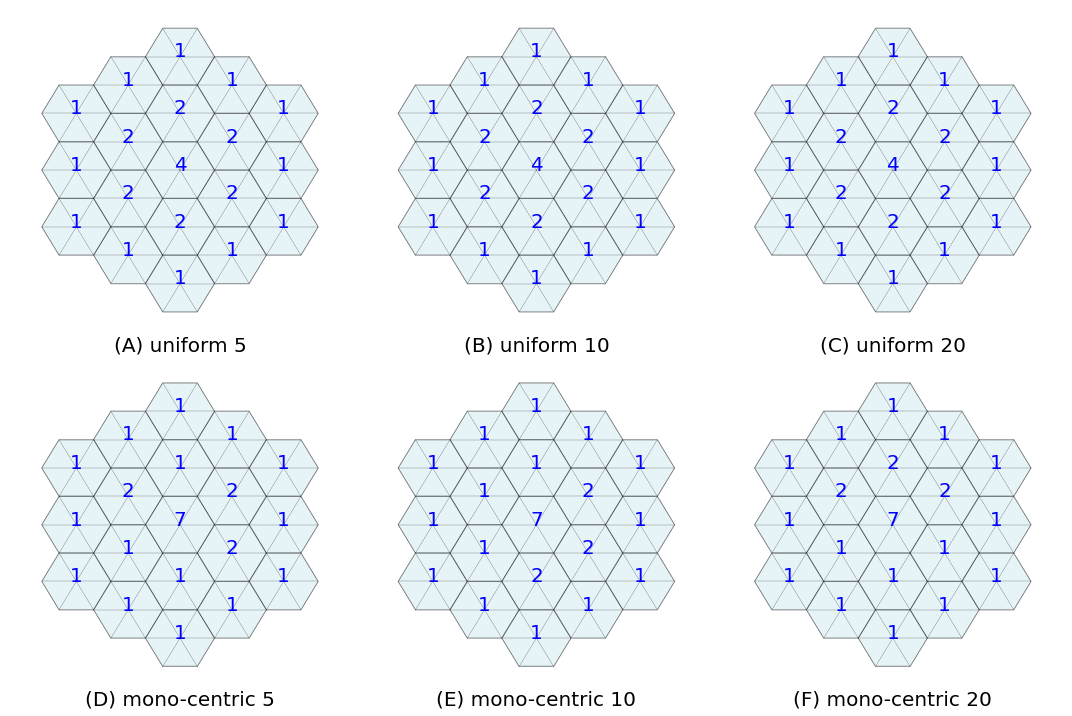

In [89]:
##########################################################################################
##########################################################################################

lambda_values = [5,10,20]

patterns=['uniform','centralized']#'centralized','uniform'

##########################################################################################
##########################################################################################

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 25}

figure, axs = plt.subplots(2,3,figsize=(15,10))

##########################################################################################
##########################################################################################

labels=['(A)','(B)','(C)','(D)','(E)','(F)']

##########################################################################################
##########################################################################################

figure_jdx=0

label_idx=0


##########################################################################################
##########################################################################################


colors=['blue','red','green']


##########################################################################################
##########################################################################################

widths=[-0.25,0,0.25]

for pattern in patterns:
    
    figure_idx=0

    for lambda_value in lambda_values:

        ##########################################################################################
        ##########################################################################################

        instance_name=pattern+" "+str(lambda_value)
        
        if 'centralized' in instance_name:
            
            instance_name='mono-centric'+" "+str(lambda_value)

        ##########################################################################################
        ##########################################################################################
        

        ##########################################################################################
        ##########################################################################################

        allocations={}

        courier_df=pd.read_csv('./02data/01/courier_instance'+str(lambda_value)+'_'+pattern+'.csv')

        courier_df=courier_df.drop(columns=['Unnamed: 0'])

        ##########################################################################################
        ##########################################################################################

        courier_df=courier_df.groupby('hexagon').count()
        
        courier_df=courier_df.reset_index()

        for idx,row in courier_df.iterrows():

            allocations[row.hexagon]=row.courier_id

        ##########################################################################################
        ##########################################################################################

        axs[figure_jdx][figure_idx].set_xlim([-5000,5000])

        axs[figure_jdx][figure_idx].set_ylim([-5000,5000])
        
        for edge in Road_Graph.edges:
    
            axs[figure_jdx][figure_idx].plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='black',linewidth=.2,linestyle='-')


        for hexagon in Hexagons:

            vertice=Hexagon_Vertices[hexagon]

            hexagon = matplotlib.patches.Polygon(vertice, closed=True, edgecolor='black', facecolor='lightblue', alpha=0.3)

            axs[figure_jdx][figure_idx].add_patch(hexagon)


        for hexagon_id, center in Hexagon_Center.items():

            axs[figure_jdx][figure_idx].text(center[0], center[1], str(int(allocations[hexagon_id])), fontsize=20, color='blue',ha='center')

        # Hide the x and y axes

        axs[figure_jdx][figure_idx].axis('off')

        ##########################################################################################
        ##########################################################################################

        axs[figure_jdx][figure_idx].text(0.5, -0.05, labels[label_idx]+' '+instance_name, ha='center', transform=axs[figure_jdx][figure_idx].transAxes,fontsize=20, fontstyle='normal')


        figure_idx+=1
        
        label_idx+=1
    
    figure_jdx+=1
        


##########################################################################################
##########################################################################################

plt.tight_layout()

current_fig = plt.gcf() 

current_fig.savefig('./07figures/07courier_region_allocation.png',dpi=1000, bbox_inches = 'tight')

plt.show()